## Libraries to be imported

In [1]:
#from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, \
average_precision_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from subprocess import call
from IPython.display import Image

## Unzip the train file

## Reading  data

In [2]:
train = pd.read_csv('gs://bucket_sepsis/train.psv', sep = "|")
val = pd.read_csv('gs://bucket_sepsis/validation.psv', sep = '|')

## Feature Engineering

### Heart Rate

Heart rate for a healthy adult is between 60 and 100. For a healthy infant it is between 70 and 190. Creating a new feature custom_hr , which is categorical variable having three values Normal, Abnormal and Missing

In [3]:
def feature_engineer_hr(train):
  train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),
            'custom_hr'] = 'abnormal'
  train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),
            'custom_hr'] = 'normal'
  train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),
            'custom_hr'] = 'normal'
  train.loc[((train['HR'] < 70) | (train['HR'] >= 190)) & (train['Age'] < 10 ),
            'custom_hr'] = 'abnormal'
  train['custom_hr'].fillna('Missing', inplace=True)
  return train

### Temperature

Temperature for a healthy human being is between 36.4 degree C to 37.6 degree C.  Creating a new feature custom_temp , which is categorical variable having three values Normal, Abnormal and Missing

In [4]:
def feature_engineer_temp(train):
  train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 
            'custom_temp'] = 'normal'
  train.loc[(train['Temp'] < 36.4) | (train['Temp'] >= 37.6), 
            'custom_temp'] = 'abnormal'

  train['custom_temp'].fillna('Missing', inplace=True)
  return train


### Age

Categorizing patient based on age to old, infant and Child/adult

In [5]:
def featuer_engineer_age(train):
  train.loc[train['Age'] >=65, 'custom_age'] = 'old'
  train.loc[train['Age'] <1, 'custom_age'] = 'infant'
  train.loc[(train['Age'] >=1) & (train['Age'] <65), 
            'custom_age'] = 'child/adult'
  return train

### O2Stat

O2Stat for a healthy adult is between 90 and 100 for healthy human beings. Create a new categorical variable custom_o2stat with levels normal, abnormal and missing

In [6]:
def feature_engineer_o2stat(train):
  train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 
            'custom_o2stat'] = 'normal'
  train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 
            'custom_o2stat'] = 'abnormal'

  train['custom_o2stat'].fillna('Missing', inplace=True)
  return train


### SBP and DBP

SBP stands for Systolic blood pressure, It is the upper number while measuring Blood pressure.
DBP stands for Diastolic blood pressure , It is the lower number while measuring Blood pressure.
Using both these columns to categorize blood pressure as low, normal, elevated , high and missing

In [7]:
def feature_engineer_blood_pressure(train):
  train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'custom_bp'] = 'low'

  train.loc[(train['SBP'].between(90,120, inclusive=True)) & 
            (train['DBP'].between(60,80, inclusive=True)), 
            'custom_bp'] = 'normal'


  train.loc[(train['SBP'].between(120,140, inclusive=True)) & 
            (train['DBP'].between(80,90, inclusive=True)), 
            'custom_bp'] = 'elevated'


  train.loc[(train['SBP'] > 140 ) & 
            (train['DBP'] > 90 ), 'custom_bp'] = 'high'

  train['custom_bp'].fillna('Missing', inplace=True)
  return train

### Respiration Rate

Respiration rate for healthy adults is between 12 and 20.  Categorizing respiratory rate as normal and abnormal based on thresholds.

In [8]:
def feature_engineer_resp_rate(train):
  train.loc[(train['Resp'].between(30,60)) & (train['Age'] <1), 
            'custom_resp'] = 'normal'
  train.loc[((train['Resp'] < 30) | (train['Resp'] > 60)) & 
             (train['Age'] <1) ,'custom_resp'] = 'abnormal'

  
  train.loc[(train['Resp'].between(24,40)) & (train['Age'].between(1,3)), 
            'custom_resp'] = 'normal'
  train.loc[((train['Resp'] < 24) | (train['Resp'] > 40)) & 
             (train['Age'].between(1,3)) ,'custom_resp'] = 'abnormal'
   
  
  train.loc[(train['Resp'].between(22,34)) & (train['Age'].between(3,6)), 
            'custom_resp'] = 'normal'
  train.loc[((train['Resp'] < 22) | (train['Resp'] > 34)) & 
             (train['Age'].between(3,6)) ,'custom_resp'] = 'abnormal'
  
  
  train.loc[(train['Resp'].between(18,30)) & (train['Age'].between(6,12)), 
            'custom_resp'] = 'normal'
  train.loc[((train['Resp'] < 18) | (train['Resp'] > 30)) & 
             (train['Age'].between(6,12)) ,'custom_resp'] = 'abnormal'

  
  train.loc[(train['Resp'].between(12,20)) & (train['Age'] >12), 
            'custom_resp'] = 'normal'
  train.loc[((train['Resp'] < 12) | (train['Resp'] > 20)) & (train['Age'] >12),
            'custom_resp'] = 'abnormal'
  
  train['custom_resp'].fillna('Missing', inplace=True)

  
  return train
  

## Transform Train and Validation sets

In [9]:
train = featuer_engineer_age(train)
train = feature_engineer_blood_pressure(train)
train = feature_engineer_hr(train)
train = feature_engineer_o2stat(train)
train = feature_engineer_temp(train)
train = feature_engineer_resp_rate(train)



val = featuer_engineer_age(val)
val = feature_engineer_blood_pressure(val)
val = feature_engineer_hr(val)
val = feature_engineer_o2stat(val)
val = feature_engineer_temp(val)
val = feature_engineer_resp_rate(val)




## Intution Based Feature Selection

According to the CDC website heart rate, fever and BP are the most important signs of sepsis. So selecting these features with the same intution

In [10]:
filtered_columns = ['Gender', 'custom_hr', 'custom_temp','custom_age', 
                    'custom_o2stat', 'custom_bp','custom_resp' ,'ICULOS', 
                    'HospAdmTime']

X_train  = train[filtered_columns]
y_train = train['SepsisLabel']

X_val  = val[filtered_columns]
y_val = val['SepsisLabel']

In [11]:
categorical = X_train.dtypes == object

categorical['Gender'] = True

## Defining the Pipeline

In [12]:
cat_pipeline = make_pipeline( OneHotEncoder(handle_unknown="ignore"))
cont_scale_pipeline = make_pipeline(SimpleImputer(strategy = "median"),
                                    StandardScaler())

preprocess_trans_scale = make_column_transformer((cont_scale_pipeline, 
                                                  ~categorical), 
                                                 (cat_pipeline, categorical))


## Custom Score function

In [13]:
def score_model(model, metric_list, y_true, y_pred):
  metric_dict = {'precision' :  precision_score, 'recall' : recall_score, 
                 'confusion_matrix' : confusion_matrix, 
                 'avg_precision': average_precision_score}
  df = pd.DataFrame()
  df['model'] = [model]
  for metric in metric_list:
    df[metric] = [metric_dict[metric](y_true, y_pred)]
  return df

# Logistic Regression

## Training Model

In [14]:
log_pipe_scale = make_pipeline(preprocess_trans_scale, 
                               LogisticRegression(C=0.01, solver = 'newton-cg',
                                                  dual=False) )

log_model = log_pipe_scale.fit(X_train, y_train)

## Prediction and Scoring

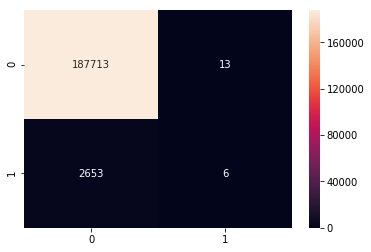

In [15]:
pred = log_pipe_scale.predict(X_val)
conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [16]:
score_model('Logistic_regression', ['recall','precision', 'avg_precision'],
            y_val, pred)

,model,recall,precision,avg_precision
0,Logistic_regression,0.002256,0.315789,0.014647


## Defining Custom Threshold

In [17]:
df = pd.DataFrame(log_pipe_scale.predict_proba(X_val))

df['actual'] = y_val
df.loc[(df[1] >=0.4), 'pred'] = 1 
df.loc[(df[1] <0.4), 'pred'] = 0 

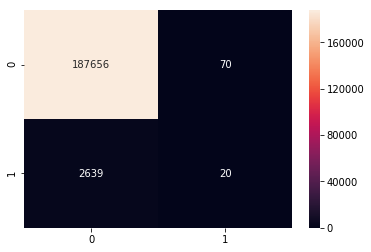

In [18]:
conf_matrix = confusion_matrix(df['actual'], df['pred'])

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [19]:
score_model('Logistic_regression', ['recall','precision','avg_precision'], 
            df['actual'], df['pred'])

,model,recall,precision,avg_precision
0,Logistic_regression,0.007522,0.222222,0.015533


In [21]:
eval_df = pd.DataFrame(log_pipe_scale.predict_proba(X_val))

eval_df['actual'] = y_val

def eval_threshold(eval_df, t_list):
    output_df = pd.DataFrame()
    avg_pre_list = []
    for threshold in t_list:
        eval_df.loc[(eval_df[1] >=threshold), 'pred'] = 1 
        eval_df.loc[(eval_df[1] <threshold), 'pred'] = 0 
        avg_pre_list.append(average_precision_score(eval_df['actual'], 
                                                    eval_df['pred']))
    output_df['threshold'] = t_list
    output_df['avg_precision'] = avg_pre_list
    return output_df
    
comp = eval_threshold(eval_df, list(np.arange(0,1,0.05)))
  
  

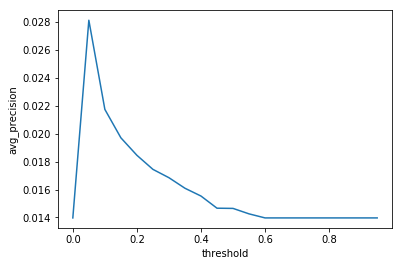

In [22]:
_=sns.lineplot(comp['threshold'], comp['avg_precision'])

## Grid Search

In [23]:
param_grid = {'logisticregression__C': [0.1, 0.01, 0.5, 1],
             'logisticregression__solver':['newton-cg', 'lbfgs', 'liblinear', 
                                           'sag', 'saga']}
grid = GridSearchCV(log_pipe_scale, param_grid, cv=3, scoring = 'average_precision', n_jobs = 3)
grid.fit(X_train, y_train)


/usr/local/lib/python3.5/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
  

In [25]:
print(grid.best_params_)

{'logisticregression__C': 0.01, 'logisticregression__solver': 'lbfgs'}


# Decision Tree

## Training the Model

In [26]:
dt_pipe_scale = make_pipeline(preprocess_trans_scale, DecisionTreeClassifier() )

dt_model = dt_pipe_scale.fit(X_train, y_train)

## Prediction and Scoring

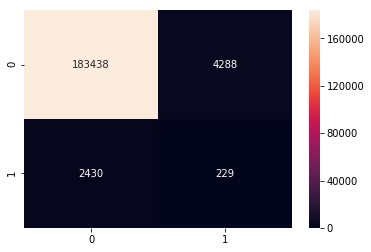

In [27]:
pred = dt_model.predict(X_val)
conf_matrix = confusion_matrix(y_val, pred)

sns.heatmap(conf_matrix, annot=True, fmt="d");

In [28]:
score_model('Decision_Tree', ['recall','precision', 'avg_precision'],
            y_val, pred)

,model,recall,precision,avg_precision
0,Decision_Tree,0.086123,0.050697,0.01713


## Display D-Tree

In [29]:
cat_names = preprocess_trans_scale.fit(X_train). \
            named_transformers_['pipeline-2'].named_steps['onehotencoder']

feature_list = list(cat_names.get_feature_names())
feature_list.extend(['ICULOS', 
                    'HospAdmTime'])


export_graphviz(DecisionTreeClassifier(max_leaf_nodes=15).fit( \
    preprocess_trans_scale.fit_transform(X_train), y_train) , 
                out_file='dt.dot',
                feature_names =feature_list ,class_names = ['normal','sepsis'],
                rounded = True, proportion = False, precision = 2
               )
call(['dot', '-Tpng', 'dt.dot', '-o', 'dt.png', '-Gdpi=600'])

Image(filename = 'dt.png', width =400, height = 400)


## Grid Search

In [30]:
param_grid = {'decisiontreeclassifier__min_samples_split': [2, 5, 10, 25],
              'decisiontreeclassifier__min_samples_leaf': [2, 5, 10, 25],
              'decisiontreeclassifier__max_depth': [5,10,15, 20, 25]}
grid = GridSearchCV(dt_pipe_scale, param_grid, cv=3, n_jobs = 3, scoring= 'average_precision')
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('simpleimputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
  

In [31]:
print(grid.best_params_)

{'decisiontreeclassifier__min_samples_leaf': 25, 'decisiontreeclassifier__min_samples_split': 2, 'decisiontreeclassifier__max_depth': 5}
